In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# SARIMA model and autocorrelation plots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

This cell constructs a Series called y that contains the target feature - in this case, hourly electricity demand.

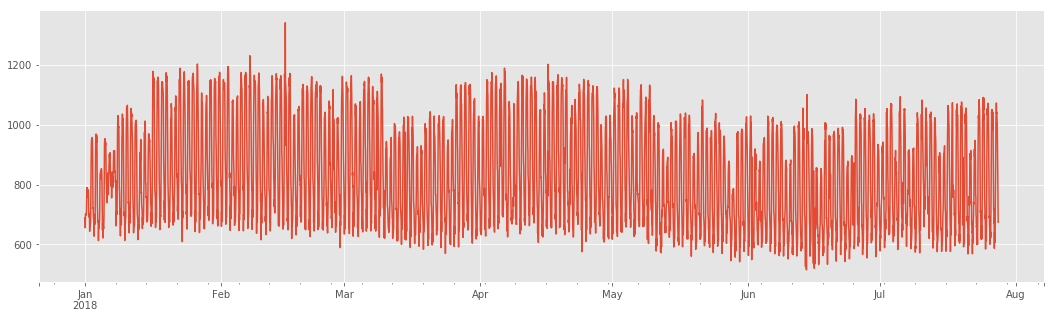

In [2]:
# read clean electricity data to create target variable array y
elec = pd.read_csv('../data/elec_clean.csv',index_col=0)
elec.index = pd.to_datetime(elec.index,format='%Y-%m-%d %H:00:00')

# remove Davenport for now because it is missing most of June and July
elec.drop('Davenport',axis=1,inplace=True)

# sum the remaining buildings
y = pd.Series(elec.iloc[:, 0:11].sum(axis=1))

y.plot(figsize=(18,5))

### Data Transformation

Many predictive models, including ARIMA, can only work with *stationary* data. In this case, that means I need to transform the data to remove median-shifting effects like school breaks and weekends.

*Transformation 1.* An average weekday and average weekend are subtracted from weekdays and weekends, respectively. This effectively captures the strikingly different behavior on weekdays and weekends.

*Transformation 2.* The average demand for each week of the year is calculated and divided from the data. This effectively captures the diminished demand due to school breaks.

After making these transformations, the series is nearly stationary, and it is ready for the ARIMA model. After the predictive modeling step, the transformations must be reversed to return useful demand values.

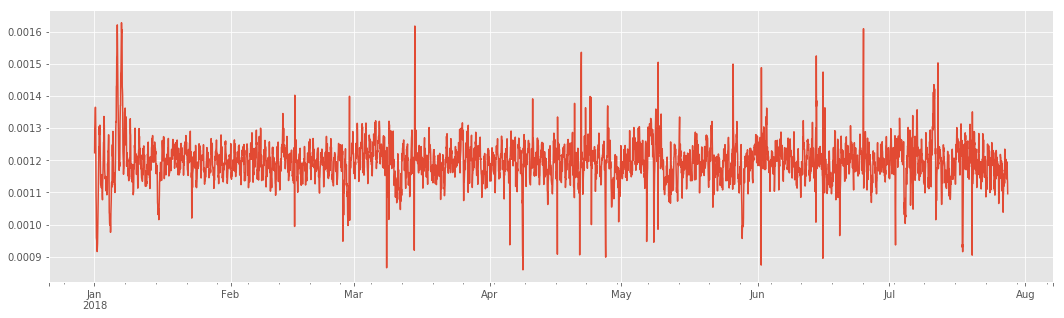

In [16]:
# complicated time operations to encode hour-of-week info
df = pd.DataFrame(y,columns=['demand'],index=y.index)
df['hourofweek'] = y.values
k=1
for i in range(len(df)):
    df['hourofweek'][i] = k
    k = k+1
    if k == 168: k=0
avg_hourofweek = y.groupby(df['hourofweek']).mean()
df['avg_hourofweek'] = df['hourofweek'].map(avg_hourofweek)
hourofweek_mean = df['avg_hourofweek'].values

# week of year calculation is easily built in to pandas
weekofyear_mean = y.index.weekofyear.map(y.groupby(y.index.weekofyear).mean()).values

# combine both week of year and hourofweek transformers
y_stationary = y/hourofweek_mean/weekofyear_mean

y_stationary.plot(figsize=(18,5))

### Autocorrelation plots

The plots below show the autocorrelation and partial autocorrelation of the raw demand data. The shaded red cone shows the 95% confidence interval, meaning all dots outside of the cone are statistically significant. The dots themselves represent lag features, where the first dot is lag by one hour, and the second by two hours. 

Following the Box-Jenkins methodology, these plots can be used to inform the type of ARIMA model to be used.
https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method

See how the 24th and 48th lag features have a strong positive correlation - this indicates that a seasonal component of 24 hours should be modeled.

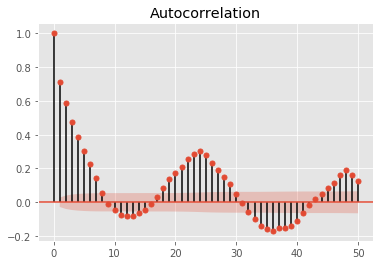

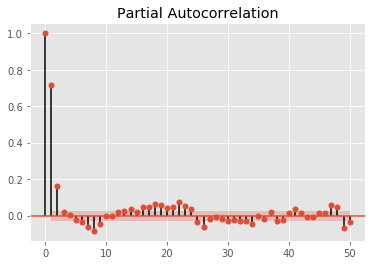

In [20]:
plot_acf(y_stationary, lags=50)
plt.show()
plot_pacf(y_stationary, lags=50)
plt.show()

### SARIMA Modeling - Encoding a seasonal element

The SARIMA (seasonal autoregressive integrated moving average) model introduces four new parameters: P,D,Q, and m. P,D, and Q are the *seasonal* autoregressive, differencing, and moving average terms, while m is the period. For the demand data, m should be 24.

The cell below trains and tests SARIMA models for several days in of the training set, starting on February 1st. The MAPE of each daily forecast is stored in the mapes DataFrame, and the predictions are stored in the y_forecast Series.

In [15]:
# construct empty dataframe to populate with results
mapes = pd.DataFrame(columns=['hours_trained','mape'])
y_forecast_stationary = y_stationary.copy(deep=True)

# define split times and end times to cut X and y into training and testing sets
split_times = pd.date_range(start='2018-02-01 08:00:00',freq='D',periods=30)
end_times = split_times.shift(39,freq='H')

# loop to run models and add hours_trained & mape data to the mapes dataframe
for i in range(len(split_times)):
    
    # define training and testing sets based on split_times and end_times
    y_train = y_stationary.loc[y.index <= split_times[i]].copy().values
    y_test = y_stationary.loc[(y.index > split_times[i]) & (y.index <= end_times[i])].copy()

    # fit the model training data, then make multi-step out-of-sample forecast
    model = SARIMAX(y_train, order=(0,0,0),seasonal_order=(1,0,1,24),enforce_stationarity=False)
    model_fit = model.fit(disp=0,maxiter=200)
    forecast = model_fit.forecast(steps=39)
    
    # store the forecast results
    y_pred = forecast
    y_forecast_stationary.loc[(y.index > split_times[i]) & (y.index <= end_times[i])] = y_pred
    
    # calculate and store the mape, then move on to the next day
    hours_trained = len(y_train)
    mape = np.mean(np.abs((y_test[15:] - y_pred[15:]) / y_test[15:]))*100
    mapes = mapes.append({'hours_trained':hours_trained,'mape':mape},ignore_index=True)

print('The average MAPE for {} test days was {}'.format(len(mapes),np.round(np.mean(mapes['mape']),2)))

/Users/kevinkoste/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NameError: name 'y_forecast_stationary' is not defined

In [14]:
# reverse the transformations
y_forecast = y_forecast_stationary*weekofyear_mean*hourofweek_mean

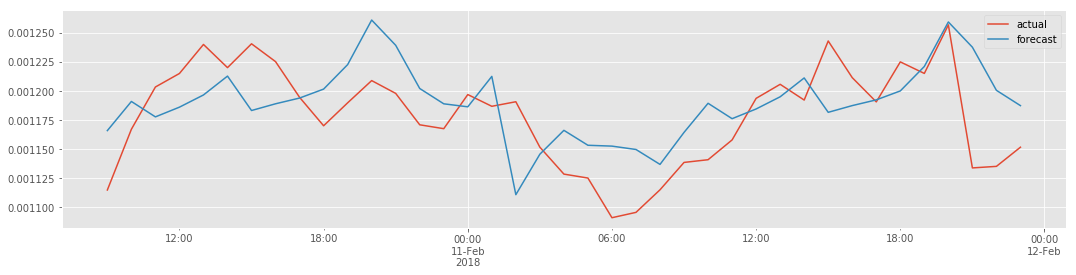

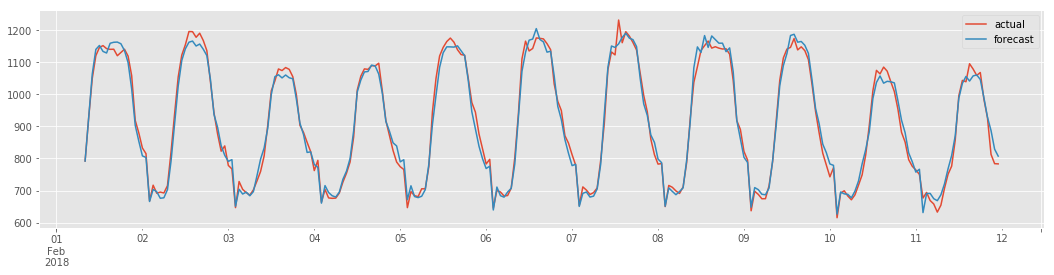

In [13]:
# plot the latest forecast and the last week of forecasts
latest_forecast = pd.DataFrame({'actual':y_test,'forecast':y_pred})
latest_forecast.plot(figsize=(18,4))

entire_forecast = pd.DataFrame({'actual':y[split_times[0]:end_times[i]],
                                'forecast':y_forecast[split_times[0]:end_times[i]]}
                              )
entire_forecast.plot(figsize=(18,4))